In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
from scipy.special import softmax
import numpy as np

np.set_printoptions(precision=3, suppress=True)
# uncomment and replace with correct path if there are import errors
# sys.path.append("/path/to/surface-sampling/")
# sys.path.append("/path/to/NeuralForceField/")
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] = "/home/dux/miniforge3/envs/htvs/bin/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from mcmc.system import SurfaceSystem

from time import perf_counter

/home/dux/NeuralForceField/models


Initialize test slab and parameters

In [3]:
# Load prepared pristine slab
element = "Si"
slab_pkl = open("data/Si_111_5x5_pristine_slab.pkl", "rb")
slab = pickle.load(slab_pkl)

system_settings = {
    "surface_name": "Si(111)_5x5",
    "cutoff": 5.0,
    "num_ads_atoms": 50,
    "near_reduce": 0.01,
    "planar_distance": 1.55,
    "no_obtuse_hollow": True,
}

sampling_settings = {
    "alpha": 1.0,  # no annealing
    "temperature": 0.1,  # in terms of kbT
    "num_sweeps": 10,
    "sweep_size": 64,
}

calc_settings = {
    "calc_name": "LAMMPS",
    "optimizer": "LAMMPS",
    "kim_potential": True,
    "chem_pots": {"Si": 0},  # change to 0 here
    "relax_atoms": True,
    "relax_steps": 100,
    "run_dir": "Si(111)_5x5",
}

Obtain adsorption sites

In [4]:
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

pristine_slab = slab.copy()
pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)

ads_positions = site_finder.find_adsorption_sites(
    put_inside=True,
    symm_reduce=False,
    near_reduce=system_settings["near_reduce"],
    distance=system_settings["planar_distance"],
    no_obtuse_hollow=system_settings["no_obtuse_hollow"],
)["all"]

print(f"adsorption coordinates are: {ads_positions[:5]}...")

adsorption coordinates are: [array([ 3.849,  2.222, 17.05 ]), array([ 5.774,  5.556, 17.05 ]), array([ 7.699,  8.89 , 17.05 ]), array([ 9.623, 12.223, 17.05 ]), array([11.548, 15.557, 17.05 ])]...


In [5]:
pristine_slab.get_tags()

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Calculate distance-based weights

In [6]:
distance_decay = True
distance_decay_factor = 2.35

from pymatgen.core.structure import Molecule

ads_mol = Molecule(["Si"], [[0, 0, 0]])

# save pymatgen sites
for ads_coord in ads_positions:
    all_ads_slab = site_finder.add_adsorbate(
        ads_mol, ads_coord, repeat=None, translate=False, reorient=False
    )
    site_finder.slab = all_ads_slab

# set tags to 1 for surface atoms
tags = np.where(np.array(all_ads_slab.site_properties["surface_atoms"]) == 1.0, 1, 0)
print(tags)
all_ads_slab.add_site_property("tags", tags)

# convert to ase
all_ads_slab_ase = AseAtomsAdaptor.get_atoms(all_ads_slab)
distances = all_ads_slab_ase.get_all_distances(mic=True)
ads_coord_distances = distances[-len(ads_positions) :, -len(ads_positions) :]
print(f"ads coords distances shape {ads_coord_distances.shape}")

# Compute distance decay matrix using softmax
distance_weight_matrix = softmax(-ads_coord_distances / distance_decay_factor, axis=1)

assert np.allclose(np.sum(distance_weight_matrix, axis=1), 1.0)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
ads coords distances shape (297, 297)


Set up LAMMPS (calculator). Requires a `lammps_config.json` and a `lammps_template.txt` in `run_dir`

In [7]:
from mcmc.calculators import LAMMPSSurfCalc

lammps_surf_calc = LAMMPSSurfCalc()
lammps_surf_calc.set(**calc_settings)

run directory: Si(111)_5x5 is set from parameters
relaxation steps: 100 is set from parameters
kim potential: True is set from parameters


Initialize surface system

In [8]:
surface = SurfaceSystem(
    pristine_slab,
    ads_positions,
    calc=lammps_surf_calc,
    surface_depth=1,
    system_settings=system_settings,
)
surface.all_atoms.write("Si_111_5x5_all_virtual_ads.cif")

2024-06-28 10:58:30,621|INFO|initializing 297 virtual atoms
2024-06-28 10:58:30,648|INFO|initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
2024-06-28 10:58:30,650|INFO|number of pristine atoms is 100
2024-06-28 10:58:30,661|INFO|bulk indices are [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 

Total wall time: 0:00:00


Test calculate pristine surface

In [9]:
print(f"Energy {surface.get_potential_energy():.3f} eV")

Total wall time: 0:00:00
Energy -379.107 eV


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `Si(111)_5x5/` folder.

2024-06-28 10:58:30,981|INFO|there are 100 atoms in pristine slab
2024-06-28 10:58:30,983|INFO|Running with num_sweeps = 10, temp = 0.1, pot = [0], alpha = 1.0
2024-06-28 10:58:30,983|INFO|In pristine slab, there are a total of 297 sites
2024-06-28 10:58:30,994|INFO|randomly adsorbing sites


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-28 10:58:33,996|INFO|running for 64 iterations per run over a total of 10 runs
2024-06-28 10:58:33,996|INFO|starting with iteration 0
2024-06-28 10:58:33,997|INFO|In sweep 1 out of 10


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
temp list is:
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:

2024-06-28 10:58:36,883|INFO|At iter 64


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-28 10:58:36,969|INFO|optim structure has Energy = -555.423130246072
2024-06-28 10:58:36,981|INFO|In sweep 2 out of 10


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-28 10:58:39,703|INFO|At iter 128
2024-06-28 10:58:39,787|INFO|optim structure has Energy = -557.0054964787774
2024-06-28 10:58:39,798|INFO|In sweep 3 out of 10


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-28 10:58:42,422|INFO|At iter 192


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-28 10:58:42,506|INFO|optim structure has Energy = -557.0054964787774
2024-06-28 10:58:42,516|INFO|In sweep 4 out of 10


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-28 10:58:45,145|INFO|At iter 256


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-28 10:58:45,230|INFO|optim structure has Energy = -557.0054964787774
2024-06-28 10:58:45,241|INFO|In sweep 5 out of 10


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-28 10:58:47,920|INFO|At iter 320


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-28 10:58:48,006|INFO|optim structure has Energy = -557.0054964787774
2024-06-28 10:58:48,016|INFO|In sweep 6 out of 10


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-28 10:58:50,673|INFO|At iter 384


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-28 10:58:50,761|INFO|optim structure has Energy = -557.0054964787774
2024-06-28 10:58:50,778|INFO|In sweep 7 out of 10


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-28 10:58:53,510|INFO|At iter 448
2024-06-28 10:58:53,593|INFO|optim structure has Energy = -557.0054964787774
2024-06-28 10:58:53,604|INFO|In sweep 8 out of 10


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-28 10:58:56,166|INFO|At iter 512


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-28 10:58:56,252|INFO|optim structure has Energy = -557.0054964787774
2024-06-28 10:58:56,262|INFO|In sweep 9 out of 10


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-28 10:58:58,977|INFO|At iter 576


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-28 10:58:59,061|INFO|optim structure has Energy = -557.0054964787774
2024-06-28 10:58:59,071|INFO|In sweep 10 out of 10


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-28 10:59:01,725|INFO|At iter 640


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-28 10:59:01,859|INFO|optim structure has Energy = -557.0054964787774


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Time taken = 31.253712924197316 seconds


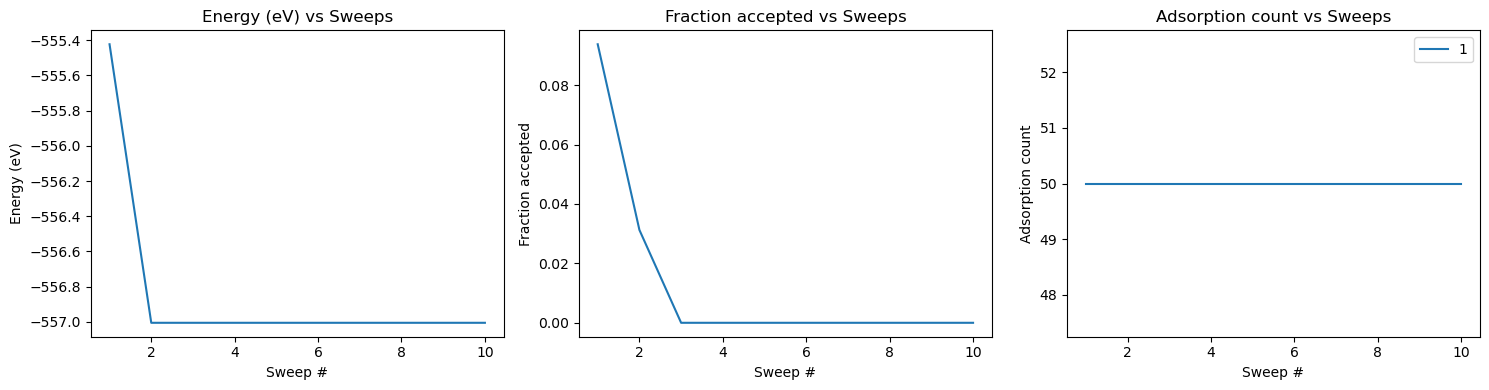

In [10]:
mcmc = MCMC(
    system_settings["surface_name"],
    calc=lammps_surf_calc,
    canonical=True,
    testing=False,
    element=element,
    adsorbates=list(calc_settings["chem_pots"].keys()),
    relax=calc_settings["relax_atoms"],
    relax_steps=calc_settings["relax_steps"],
    optimizer=calc_settings["optimizer"],
    num_ads_atoms=system_settings["num_ads_atoms"],
)

start = perf_counter()
# TODO: convert input to sampling settings
mcmc.mcmc_run(
    total_sweeps=sampling_settings["num_sweeps"],
    sweep_size=sampling_settings["sweep_size"],
    start_temp=sampling_settings["temperature"],
    pot=list(calc_settings["chem_pots"].values()),
    alpha=sampling_settings["alpha"],
    surface=surface,
)
stop = perf_counter()
print(f"Time taken = {stop - start} seconds")